# Q-GAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [2]:
import numpy as np

In [3]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [4]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.01932118 -0.20522046  0.02098161  0.32420111] 0 1.0 False {}
state, action, reward, done, info
[ 0.01521677 -0.01040345  0.02746563  0.03820805] 1 1.0 False {}
state, action, reward, done, info
[ 0.0150087   0.18431409  0.02822979 -0.24568423] 1 1.0 False {}
state, action, reward, done, info
[ 0.01869498 -0.01119944  0.02331611  0.05576768] 0 1.0 False {}
state, action, reward, done, info
[ 0.018471    0.18358057  0.02443146 -0.2294686 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.02214261  0.37834503  0.01984209 -0.51434597] 1 1.0 False {}
state, action, reward, done, info
[ 0.02970951  0.573182    0.00955517 -0.8007107 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.04117315  0.76817159 -0.00645904 -1.09037257] 1 1.0 False {}
state, action, reward, done, info
[ 0.05653658  0.96337809 -0.0282665  -1.38507515] 1 1.0 False {}
state, action, reward, done, info
[ 0.07580414  1.15884088 -0.055968   -1.68646146] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1588408840355289 -1.6864614638868696


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [7]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [12]:
# Q: Qfunction/Encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        # return actions logits
        return logits

In [13]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [14]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [15]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [16]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt 

In [17]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            next_states=self.next_states, hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [30]:
train_episodes = 500          # max number of episodes to learn from
max_steps = 2000               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [31]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [33]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/Q-GAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 4.0 Average reward fake: 0.4996602535247803 Average reward real: 0.5107257962226868 Training d_loss: 1.3654 Training g_loss: 0.6938 Training q_loss: 0.3732 Explore P: 0.9996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 23.0 Average reward fake: 0.5017067193984985 Average reward real: 0.5169975757598877 Training d_loss: 1.3612 Training g_loss: 0.6897 Training q_loss: 0.6118 Explore P: 0.9973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 8.0 Average reward fake: 0.5013338923454285 Average reward real: 0.4972912669181824 Training d_loss: 1.3991 Training g_loss: 0.6905 Training q_loss: 0.4966 Explore P: 0.9965
--

-------------------------------------------------------------------------------
Episode: 24 Total reward: 16.0 Average reward fake: 0.45345640182495117 Average reward real: 0.4273253083229065 Training d_loss: 1.5843 Training g_loss: 0.7897 Training q_loss: 70.6124 Explore P: 0.9579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 13.0 Average reward fake: 0.4661548137664795 Average reward real: 0.4876793920993805 Training d_loss: 1.4446 Training g_loss: 0.7602 Training q_loss: 1.6991 Explore P: 0.9566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 26 Total reward: 9.0 Average reward fake: 0.48290354013442993 Average reward real: 0.46079978346824646 Training d_loss: 1.5263 Training g_loss: 0.7361 Training q_loss: 1.4248 Explore P: 0

-------------------------------------------------------------------------------
Episode: 47 Total reward: 22.0 Average reward fake: 0.49719128012657166 Average reward real: 0.43327468633651733 Training d_loss: 1.5581 Training g_loss: 0.6988 Training q_loss: 0.6318 Explore P: 0.9155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 12.0 Average reward fake: 0.4983108639717102 Average reward real: 0.4866876006126404 Training d_loss: 1.4327 Training g_loss: 0.6971 Training q_loss: 2.2604 Explore P: 0.9144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 29.0 Average reward fake: 0.5579544901847839 Average reward real: 0.5139913558959961 Training d_loss: 1.5145 Training g_loss: 0.5831 Training q_loss: 58.3690 Explore P: 0

-------------------------------------------------------------------------------
Episode: 71 Total reward: 13.0 Average reward fake: 0.44895458221435547 Average reward real: 0.6330411434173584 Training d_loss: 1.0706 Training g_loss: 0.8052 Training q_loss: 74.6742 Explore P: 0.8577
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 47.0 Average reward fake: 0.5769604444503784 Average reward real: 0.4857664704322815 Training d_loss: 1.6189 Training g_loss: 0.5498 Training q_loss: 0.9320 Explore P: 0.8537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 27.0 Average reward fake: 0.4848254323005676 Average reward real: 0.49169501662254333 Training d_loss: 1.3807 Training g_loss: 0.7248 Training q_loss: 23.8517 Explore P: 

-------------------------------------------------------------------------------
Episode: 94 Total reward: 17.0 Average reward fake: 0.43830862641334534 Average reward real: 0.49156028032302856 Training d_loss: 1.3563 Training g_loss: 0.8248 Training q_loss: 8.9079 Explore P: 0.7999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 12.0 Average reward fake: 0.44955530762672424 Average reward real: 0.38335293531417847 Training d_loss: 1.6158 Training g_loss: 0.8008 Training q_loss: 71.9798 Explore P: 0.7990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 96 Total reward: 17.0 Average reward fake: 0.5035148859024048 Average reward real: 0.4302602708339691 Training d_loss: 1.5559 Training g_loss: 0.6865 Training q_loss: 1.8025 Explore P:

-------------------------------------------------------------------------------
Episode: 117 Total reward: 20.0 Average reward fake: 0.512348473072052 Average reward real: 0.4688819944858551 Training d_loss: 1.4830 Training g_loss: 0.6692 Training q_loss: 2.7082 Explore P: 0.7475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 13.0 Average reward fake: 0.5502066016197205 Average reward real: 0.5034774541854858 Training d_loss: 1.4893 Training g_loss: 0.5974 Training q_loss: 2.4071 Explore P: 0.7465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 119 Total reward: 26.0 Average reward fake: 0.5103080868721008 Average reward real: 0.5178337693214417 Training d_loss: 1.3764 Training g_loss: 0.6734 Training q_loss: 49.1195 Explore P: 0

-------------------------------------------------------------------------------
Episode: 140 Total reward: 61.0 Average reward fake: 0.38744935393333435 Average reward real: 0.5065024495124817 Training d_loss: 1.2017 Training g_loss: 0.9760 Training q_loss: 7.6899 Explore P: 0.6779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 18.0 Average reward fake: 0.44183477759361267 Average reward real: 0.48185890913009644 Training d_loss: 1.3348 Training g_loss: 0.8196 Training q_loss: 20.3160 Explore P: 0.6767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 57.0 Average reward fake: 0.6570660471916199 Average reward real: 0.5095509886741638 Training d_loss: 1.8758 Training g_loss: 0.4388 Training q_loss: 59.5012 Explore

-------------------------------------------------------------------------------
Episode: 164 Total reward: 54.0 Average reward fake: 0.5045982003211975 Average reward real: 0.45322394371032715 Training d_loss: 1.5274 Training g_loss: 0.6846 Training q_loss: 574.8917 Explore P: 0.5905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 28.0 Average reward fake: 0.4031727910041809 Average reward real: 0.5146746039390564 Training d_loss: 1.2066 Training g_loss: 0.9085 Training q_loss: 881.7775 Explore P: 0.5888
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 81.0 Average reward fake: 0.45656663179397583 Average reward real: 0.5301281809806824 Training d_loss: 1.2690 Training g_loss: 0.7824 Training q_loss: 55.9591 Explo

-------------------------------------------------------------------------------
Episode: 187 Total reward: 199.0 Average reward fake: 0.5212600827217102 Average reward real: 0.457103967666626 Training d_loss: 1.5375 Training g_loss: 0.6569 Training q_loss: 34.2129 Explore P: 0.4744
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 188 Total reward: 174.0 Average reward fake: 0.5191749334335327 Average reward real: 0.5486916303634644 Training d_loss: 1.3464 Training g_loss: 0.6568 Training q_loss: 369.3465 Explore P: 0.4664
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 189 Total reward: 132.0 Average reward fake: 0.48754873871803284 Average reward real: 0.4787377417087555 Training d_loss: 1.4073 Training g_loss: 0.7182 Training q_loss: 118.8976 Expl

-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Average reward fake: 0.49362725019454956 Average reward real: 0.5011131763458252 Training d_loss: 1.3858 Training g_loss: 0.7073 Training q_loss: 323.3744 Explore P: 0.3437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 123.0 Average reward fake: 0.49361711740493774 Average reward real: 0.48510393500328064 Training d_loss: 1.4142 Training g_loss: 0.7064 Training q_loss: 116.9058 Explore P: 0.3396
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 199.0 Average reward fake: 0.48246216773986816 Average reward real: 0.5936147570610046 Training d_loss: 1.2687 Training g_loss: 0.7922 Training q_loss: 199.5269

-------------------------------------------------------------------------------
Episode: 233 Total reward: 199.0 Average reward fake: 0.47250527143478394 Average reward real: 0.4975593686103821 Training d_loss: 1.3416 Training g_loss: 0.7497 Training q_loss: 170.2243 Explore P: 0.2341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 175.0 Average reward fake: 0.49049878120422363 Average reward real: 0.49667638540267944 Training d_loss: 1.3844 Training g_loss: 0.7124 Training q_loss: 29.0775 Explore P: 0.2302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 199.0 Average reward fake: 0.5608739256858826 Average reward real: 0.5071154832839966 Training d_loss: 1.5123 Training g_loss: 0.5789 Training q_loss: 42.8572 Ex

-------------------------------------------------------------------------------
Episode: 256 Total reward: 182.0 Average reward fake: 0.5056480169296265 Average reward real: 0.5109239816665649 Training d_loss: 1.3884 Training g_loss: 0.6819 Training q_loss: 824.4523 Explore P: 0.1596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 165.0 Average reward fake: 0.4782989025115967 Average reward real: 0.4868578314781189 Training d_loss: 1.3720 Training g_loss: 0.7375 Training q_loss: 8.5854 Explore P: 0.1572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 258 Total reward: 158.0 Average reward fake: 0.5101243853569031 Average reward real: 0.45339685678482056 Training d_loss: 1.5352 Training g_loss: 0.6729 Training q_loss: 17.8934 Explo

-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average reward fake: 0.5692329406738281 Average reward real: 0.5311194658279419 Training d_loss: 1.4985 Training g_loss: 0.5723 Training q_loss: 16.3640 Explore P: 0.1104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 199.0 Average reward fake: 0.48482465744018555 Average reward real: 0.5351628661155701 Training d_loss: 1.2983 Training g_loss: 0.7266 Training q_loss: 9.7462 Explore P: 0.1084
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 183.0 Average reward fake: 0.46700018644332886 Average reward real: 0.505249559879303 Training d_loss: 1.3449 Training g_loss: 0.7718 Training q_loss: 43.7687 Explor

-------------------------------------------------------------------------------
Episode: 302 Total reward: 199.0 Average reward fake: 0.5424084663391113 Average reward real: 0.5853322744369507 Training d_loss: 1.3315 Training g_loss: 0.6120 Training q_loss: 328.2972 Explore P: 0.0738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 199.0 Average reward fake: 0.5346643924713135 Average reward real: 0.48047488927841187 Training d_loss: 1.5140 Training g_loss: 0.6262 Training q_loss: 51.0267 Explore P: 0.0725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 304 Total reward: 199.0 Average reward fake: 0.4705526828765869 Average reward real: 0.4549539089202881 Training d_loss: 1.4527 Training g_loss: 0.7541 Training q_loss: 20.5346 Expl

-------------------------------------------------------------------------------
Episode: 325 Total reward: 199.0 Average reward fake: 0.5010042190551758 Average reward real: 0.4706033766269684 Training d_loss: 1.4769 Training g_loss: 0.6948 Training q_loss: 1139.5807 Explore P: 0.0505
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 199.0 Average reward fake: 0.42171210050582886 Average reward real: 0.43207651376724243 Training d_loss: 1.4257 Training g_loss: 0.8838 Training q_loss: 36.1382 Explore P: 0.0497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 199.0 Average reward fake: 0.5229026079177856 Average reward real: 0.4516686499118805 Training d_loss: 1.5603 Training g_loss: 0.6495 Training q_loss: 109.4415 E

-------------------------------------------------------------------------------
Episode: 348 Total reward: 186.0 Average reward fake: 0.5194801092147827 Average reward real: 0.46781960129737854 Training d_loss: 1.5145 Training g_loss: 0.6551 Training q_loss: 20.8104 Explore P: 0.0356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Average reward fake: 0.4797733724117279 Average reward real: 0.4903627336025238 Training d_loss: 1.3753 Training g_loss: 0.7345 Training q_loss: 15.8787 Explore P: 0.0351
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 177.0 Average reward fake: 0.4133342206478119 Average reward real: 0.5245641469955444 Training d_loss: 1.1909 Training g_loss: 0.8844 Training q_loss: 27.1793 Explo

-------------------------------------------------------------------------------
Episode: 371 Total reward: 193.0 Average reward fake: 0.5447731018066406 Average reward real: 0.5305923819541931 Training d_loss: 1.4240 Training g_loss: 0.6075 Training q_loss: 30.6142 Explore P: 0.0267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 166.0 Average reward fake: 0.513572096824646 Average reward real: 0.526967465877533 Training d_loss: 1.3695 Training g_loss: 0.6670 Training q_loss: 13.2952 Explore P: 0.0264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 162.0 Average reward fake: 0.4000629484653473 Average reward real: 0.5000779628753662 Training d_loss: 1.2066 Training g_loss: 0.9162 Training q_loss: 21.2723 Explore 

-------------------------------------------------------------------------------
Episode: 394 Total reward: 199.0 Average reward fake: 0.5224792957305908 Average reward real: 0.5193847417831421 Training d_loss: 1.4094 Training g_loss: 0.6571 Training q_loss: 5.0036 Explore P: 0.0210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 199.0 Average reward fake: 0.47528165578842163 Average reward real: 0.6246371865272522 Training d_loss: 1.1569 Training g_loss: 0.7484 Training q_loss: 15.4348 Explore P: 0.0208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 199.0 Average reward fake: 0.5183393955230713 Average reward real: 0.4430616796016693 Training d_loss: 1.5773 Training g_loss: 0.6656 Training q_loss: 23.3191 Explor

-------------------------------------------------------------------------------
Episode: 417 Total reward: 163.0 Average reward fake: 0.5123401284217834 Average reward real: 0.4419248700141907 Training d_loss: 1.5443 Training g_loss: 0.6690 Training q_loss: 6.4326 Explore P: 0.0172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 142.0 Average reward fake: 0.4515821039676666 Average reward real: 0.509697675704956 Training d_loss: 1.3544 Training g_loss: 0.7985 Training q_loss: 3.0517 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 182.0 Average reward fake: 0.495899498462677 Average reward real: 0.4892897605895996 Training d_loss: 1.4071 Training g_loss: 0.7014 Training q_loss: 19.7372 Explore P:

-------------------------------------------------------------------------------
Episode: 440 Total reward: 194.0 Average reward fake: 0.47477826476097107 Average reward real: 0.4513475000858307 Training d_loss: 1.4431 Training g_loss: 0.7449 Training q_loss: 6.6242 Explore P: 0.0148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 166.0 Average reward fake: 0.5027857422828674 Average reward real: 0.47946175932884216 Training d_loss: 1.4416 Training g_loss: 0.6876 Training q_loss: 4.4863 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 199.0 Average reward fake: 0.5847398638725281 Average reward real: 0.523079514503479 Training d_loss: 1.5279 Training g_loss: 0.5364 Training q_loss: 5.8091 Explore 

-------------------------------------------------------------------------------
Episode: 463 Total reward: 199.0 Average reward fake: 0.466515451669693 Average reward real: 0.5028783679008484 Training d_loss: 1.3217 Training g_loss: 0.7625 Training q_loss: 41.4408 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 199.0 Average reward fake: 0.4134750962257385 Average reward real: 0.4841054081916809 Training d_loss: 1.2668 Training g_loss: 0.8857 Training q_loss: 1.8236 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 199.0 Average reward fake: 0.48985162377357483 Average reward real: 0.5427948236465454 Training d_loss: 1.2919 Training g_loss: 0.7144 Training q_loss: 5.0704 Explore 

-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.4936966001987457 Average reward real: 0.5089961886405945 Training d_loss: 1.3593 Training g_loss: 0.7059 Training q_loss: 1.8089 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 197.0 Average reward fake: 0.47140511870384216 Average reward real: 0.486855685710907 Training d_loss: 1.3626 Training g_loss: 0.7519 Training q_loss: 12.9018 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 199.0 Average reward fake: 0.4807099401950836 Average reward real: 0.48637786507606506 Training d_loss: 1.3781 Training g_loss: 0.7325 Training q_loss: 1.6814 Explore

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

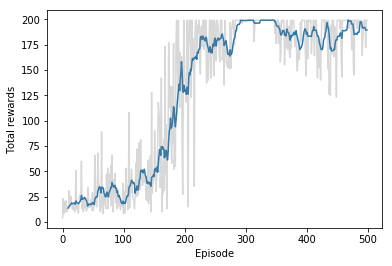

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

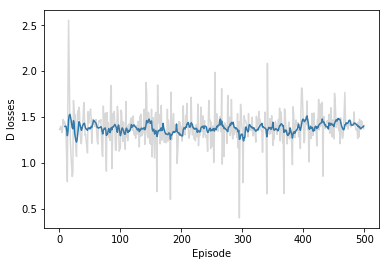

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

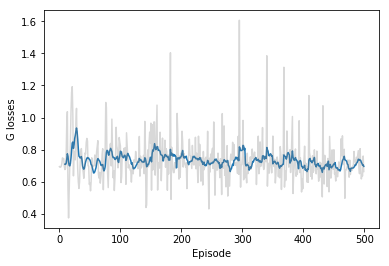

In [37]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

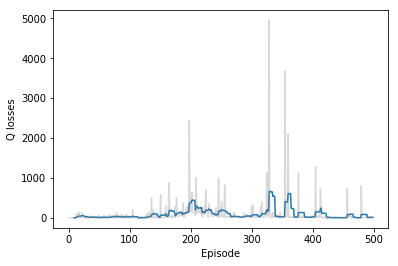

In [38]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 5
test_max_steps = 200
env.reset()

# Now train with experiences
saver = tf.train.Saver()

with tf.Session() as sess:
    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.